# Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

---

## I. Feature extraction

This section shows how to perform a histogram of oriented gradients (HOG) feature extraction on a set of images as well as to apply a color transform and append binned color features and histograms of color, to the HOG feature vector. These steps are:

* Reading in all the `vehicle` and `non-vehicle` images
* Compute color features of the image
* Compute color histogram features  
* Compute HOG features and give visualization
* concatenate all features

Following are the details:

---

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
#%matplotlib qt
%matplotlib inline

In [2]:
# This is a function which garrenties that the type of the image is uint8
def dtype2uint8(img):
    if img.dtype != 'uint8':
        result = np.uint8(img*255)
    else:
        result = img.copy()
    return result

### 1.1 Data Exploration

#### 1.1.1 Reading in images

In [3]:
# Reading in both vehicle images and non-vehicle images provided by the Udacity
vehicle_files = [name for name in glob.glob('./vehicles/*/*.png')]
nonvehicle_files = [name for name in glob.glob('./non-vehicles/*/*.png')]
print('The number of vehicle images is {}.'.format(len(vehicle_files)))
print('The number of non-vehicle images is {}.'.format(len(nonvehicle_files)))

The number of vehicle images is 8792.
The number of non-vehicle images is 8968.


#### 1.1.2 Show example image

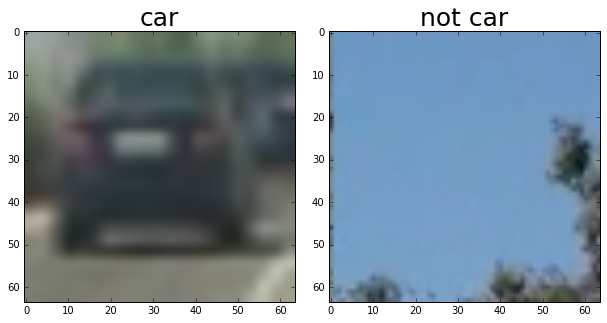

In [4]:
# Show an example of the vehicle image and non-vehicle image
import matplotlib.image as mpimg

vehicle_example = dtype2uint8(mpimg.imread(vehicle_files[0]))
nonvehicle_example = dtype2uint8(mpimg.imread(nonvehicle_files[0]))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
f.tight_layout()
ax1.imshow(vehicle_example)
ax1.set_title('car', fontsize=25)
ax2.imshow(nonvehicle_example)
ax2.set_title('not car', fontsize=25)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

### 1.2 Multiple feature extraction

In [5]:
import time
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#### 1.2.1 Color features extraction

In [6]:
# Define a function to compute binned color features  
def bin_spatial(image, spatial_size=(32, 32)):
    img = dtype2uint8(image)
    img = cv2.resize(img, spatial_size)
    # Use ravel() to create the feature vector
    features = img.ravel() 
    # Return the feature vector
    return features

#### 1.2.2 Color histogram features extraction

In [7]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    img = dtype2uint8(img)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

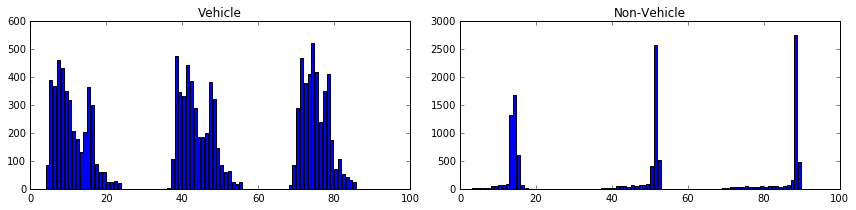

In [8]:
# Show an example of the color histogram feature
vch_example = color_hist(vehicle_example, nbins=32, bins_range=(0, 256))
nvch_example = color_hist(nonvehicle_example, nbins=32, bins_range=(0, 256))

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.bar(range(len(vch_example)), vch_example)
#plt.xlim(0, 256)
plt.title('Vehicle')
plt.subplot(122)
plt.bar(range(len(nvch_example)), nvch_example)
#plt.xlim(0, 256)
plt.title('Non-Vehicle')
fig.tight_layout()

#### 1.2.3 HOG features extraction

In [9]:
# Define a function to return HOG features and visualization
def get_hog_features(img, 
                     orient = 9, 
                     pix_per_cell = 8, 
                     cell_per_block = 2, 
                     vis=False, 
                     feature_vec=True):
    img = dtype2uint8(img)
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

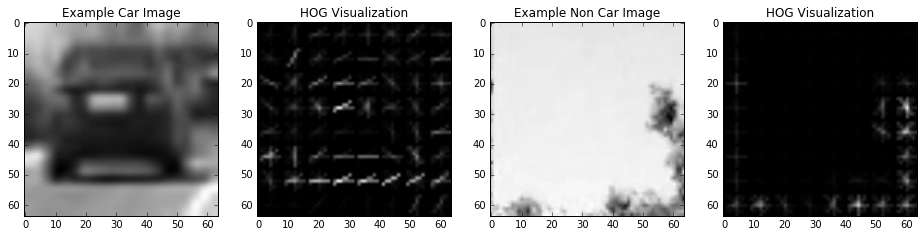

In [10]:
# Give an example of the HOG feture
vhog_features, vhog_image = get_hog_features(cv2.cvtColor(vehicle_example, cv2.COLOR_RGB2LUV)[:,:,0], 
                                             orient = 8, 
                                             pix_per_cell = 8, 
                                             cell_per_block = 1, 
                                             vis=True, feature_vec=True)
nvhog_features, nvhog_image = get_hog_features(cv2.cvtColor(nonvehicle_example, cv2.COLOR_RGB2LUV)[:,:,0], 
                                               orient = 8, 
                                               pix_per_cell = 8, 
                                               cell_per_block = 1, 
                                               vis=True, feature_vec=True)


# Plot the examples
fig = plt.figure(figsize=(16,4))
plt.subplot(141)
plt.imshow(cv2.cvtColor(vehicle_example, cv2.COLOR_RGB2LUV)[:,:,0], cmap='gray')
plt.title('Example Car Image')
plt.subplot(142)
plt.imshow(vhog_image, cmap='gray')
plt.title('HOG Visualization')
plt.subplot(143)
plt.imshow(cv2.cvtColor(nonvehicle_example, cv2.COLOR_RGB2LUV)[:,:,0], cmap='gray')
plt.title('Example Non Car Image')
plt.subplot(144)
plt.imshow(nvhog_image, cmap='gray')
plt.title('HOG Visualization')

#### 1.2.4 Wrap them up

In [11]:
# Define a function to extract all features from a list of images
def extract_features(imgs, cspace='RGB', 
                     resize=(32, 32), 
                     spatial_size=(16, 16), 
                     hist_bins=32, hist_range=(0, 256), 
                     orient = 8, pix_per_cell = 4, cell_per_block = 1, 
                     vis=False, feature_vec=True, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = dtype2uint8(mpimg.imread(file))
        image = cv2.resize(image, resize)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, spatial_size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    # Return list of feature vectors
    return features

## II. Training Classifier

This section introduce the steps used for training a classifier to distinguish vehicle images and non-vehicle images. These steps are:

* Transform the dataset from the RGB color space to the feature space
* Normalize the features so that they have zero mean and unit variance
* Random shuffle the data and split the data into a training and testing set to avoid overfitting
* Train a linear support vector machine classifier and test its performance

Details are given bellow:

---

### 2.1 Data Preparation

#### 2.1.1 Feature extraction

In [12]:
vehicle_features = extract_features(vehicle_files, cspace='LUV', 
                                    resize=(32, 32), 
                                    spatial_size=(16, 16), 
                                    hist_bins=32, hist_range=(0, 256), 
                                    orient = 8, pix_per_cell = 4, cell_per_block = 1, 
                                    vis=False, feature_vec=True, hog_channel=0)
nonvehicle_features = extract_features(nonvehicle_files, cspace='LUV', 
                                       resize=(32, 32), 
                                       spatial_size=(16, 16), 
                                       hist_bins=32, hist_range=(0, 256), 
                                       orient = 8, pix_per_cell = 4, cell_per_block = 1, 
                                       vis=False, feature_vec=True, hog_channel=0)

#### 2.1.2 Feature normalization

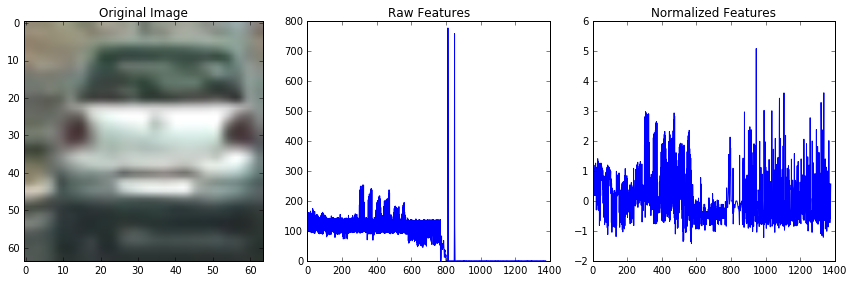

In [13]:
# Create an array stack of feature vectors
X = np.vstack((vehicle_features, nonvehicle_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
car_ind = 99
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(vehicle_files[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()

In [14]:
# Define the labels vector
y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(nonvehicle_features))))

### 2.2 Training Classifier

#### 2.2.1 Split up data

In [15]:
# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.1)

#### 2.2.2 Train an SVC

In [16]:
from sklearn.svm import SVC

In [ ]:
# Train a linear SVC 
#svc = LinearSVC()
svc = SVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print('It costs', round(t2-t, 2), 'seconds to train the SVC classifier.')

In [ ]:
from sklearn.externals import joblib
joblib.dump(svc, 'svc.pkl') 

In [17]:
from sklearn.externals import joblib
svc = joblib.load('svc.pkl') 

#### 2.2.3 Evaluate the classifier

In [18]:
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Test Accuracy of SVC =  0.9989
My SVC predicts:  [ 0.  1.  1.  1.  0.  1.  1.  0.  0.  1.]
For these 10 labels:  [ 0.  1.  1.  1.  0.  1.  1.  0.  0.  1.]
0.03579 Seconds to predict 10 labels with SVC


## III. Sliding Window Search

This section realize the sliding window search technique. This method involves the following steps:

* Extraction windows of varias sizes
* Resize and transform each extracted window into the feature space
* Normalize and classify each feature
* Record windows containing cars and combine overlapping detections

Following are the details:

---

### 3.1 Sliding window extraction

In [19]:
# Here is the draw_boxes function
def draw_boxes(img, bboxes, factor=1, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = dtype2uint8(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        if np.random.randint(0, factor) == 0:
            cv2.rectangle(imcopy, tuple(bbox[0]), tuple(bbox[1]), color, thick)
    # Return the image copy with boxes drawn
    return imcopy

#### 3.1.1 Window extraction function

In [20]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    img = dtype2uint8(image)
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] is None:
        x_start_stop[0] = 0
    if x_start_stop[1] is None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] is None:
        y_start_stop[0] = 0
    if y_start_stop[1] is None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

#### 3.1.2 Best window combination

The number of small windows is 312
The number of middel windows is 195
The number of large windows is 38
The total number of windows is 545


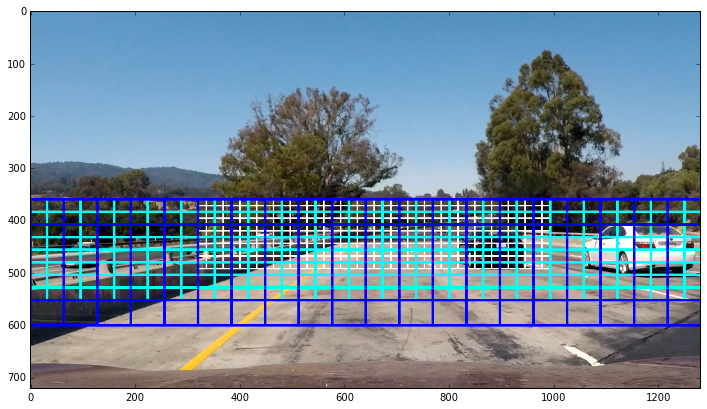

In [21]:
# Combine all kinds of windows that are useful
image = mpimg.imread('./test_images/test1.jpg')
small_windows = slide_window(image, 
                             x_start_stop=[int(image.shape[1]*8/32), int(image.shape[1]*24/32)], 
                             y_start_stop=[int(image.shape[0]*16/32), int(image.shape[0]*21/32)], 
                             xy_window=(64, 48), 
                             xy_overlap=(0.75, 0.75))
middle_windows = slide_window(image, 
                              x_start_stop=[int(image.shape[1]*0/32), int(image.shape[1]*32/32)], 
                              y_start_stop=[int(image.shape[0]*16/32), int(image.shape[0]*23/32)], 
                              xy_window=(128, 96), 
                              xy_overlap=(0.75, 0.75))
large_windows = slide_window(image, 
                             x_start_stop=[int(image.shape[1]*0/32), int(image.shape[1]*32/32)], 
                             y_start_stop=[int(image.shape[0]*16/32), int(image.shape[0]*24/32)], 
                             xy_window=(256, 192), 
                             xy_overlap=(0.75, 0.75))

window_img = draw_boxes(image, small_windows, factor=1, color=(255, 255, 255), thick=2)
window_img = draw_boxes(window_img, middle_windows, factor=1, color=(0, 255, 255), thick=3)
window_img = draw_boxes(window_img, large_windows, factor=1, color=(0, 0, 255), thick=4)

all_windows = np.vstack([small_windows, 
                         middle_windows, 
                         large_windows])

fig = plt.figure(figsize=(12,8))
plt.imshow(window_img)
print('The number of small windows is {}'.format(len(small_windows)))
print('The number of middel windows is {}'.format(len(middle_windows)))
print('The number of large windows is {}'.format(len(large_windows)))
print('The total number of windows is {}'.format(len(all_windows)))

### 3.2 Classify each window

#### 3.2.1 Single image normalized feature extraction

In [22]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, cspace='RGB', 
                        resize=(32, 32), 
                        spatial_size=(16, 16), 
                        hist_bins=32, hist_range=(0, 256), 
                        orient = 8, pix_per_cell = 4, cell_per_block = 1, 
                        vis=False, feature_vec=True, hog_channel=0, 
                        X_scaler = None):

    image = dtype2uint8(img)
    image = cv2.resize(image, resize)
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    else: feature_image = np.copy(image)      
    # Apply bin_spatial() to get spatial color features
    spatial_features = bin_spatial(feature_image, spatial_size=spatial_size)
    # Apply color_hist() also with a color space option now
    hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
    # Call get_hog_features() with vis=False, feature_vec=True
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
    # Append the new feature vector to the features list
    raw_feature = np.concatenate((spatial_features, hist_features, hog_features))
    feature = raw_feature
    if X_scaler is not None:
        # Apply the scaler to X
        feature = X_scaler.transform(raw_feature.reshape(1, -1))
    # Return list of feature vectors
    return feature

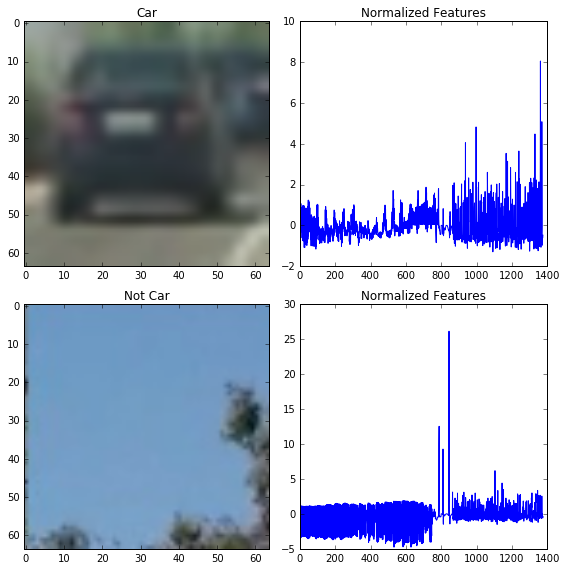

In [23]:
# Show an example of the feature
vf_example = single_img_features(vehicle_example, cspace='LUV', 
                                 resize=(32, 32), 
                                 spatial_size=(16, 16), 
                                 hist_bins=32, hist_range=(0, 256), 
                                 orient = 8, pix_per_cell = 4, cell_per_block = 1, 
                                 vis=False, feature_vec=True, hog_channel=0, 
                                 X_scaler = X_scaler)
nvf_example = single_img_features(nonvehicle_example, cspace='LUV', 
                                  resize=(32, 32), 
                                  spatial_size=(16, 16), 
                                  hist_bins=32, hist_range=(0, 256), 
                                  orient = 8, pix_per_cell = 4, cell_per_block = 1, 
                                  vis=False, feature_vec=True, hog_channel=0, 
                                  X_scaler = X_scaler)

# Plot an example of scaled features
fig = plt.figure(figsize=(8,8))
plt.subplot(221)
plt.imshow(vehicle_example)
plt.title('Car')
plt.subplot(222)
plt.plot(vf_example.squeeze())
plt.title('Normalized Features')
plt.subplot(223)
plt.imshow(nonvehicle_example)
plt.title('Not Car')
plt.subplot(224)
plt.plot(nvf_example.squeeze())
plt.title('Normalized Features')
fig.tight_layout()

#### 3.2.2 Search windows

In [24]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(image, windows, clf, color_space='LUV', 
                   resize=(32, 32), 
                   spatial_size=(16, 16), 
                   hist_bins=32, hist_range=(0, 256), 
                   orient=8, pix_per_cell=4, cell_per_block=1, 
                   vis=False, feature_vec=True, hog_channel=0, 
                   X_scaler = None):

    img = dtype2uint8(image)
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = img[window[0][1]:window[1][1], window[0][0]:window[1][0]]    
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, cspace=color_space, 
                                       resize=resize, 
                                       spatial_size=spatial_size, 
                                       hist_bins=hist_bins, hist_range=hist_range, 
                                       orient = orient, pix_per_cell = pix_per_cell, cell_per_block = cell_per_block, 
                                       vis=vis, feature_vec=feature_vec, hog_channel=hog_channel, 
                                       X_scaler = X_scaler)
        #4) Predict using your classifier
        prediction = clf.predict(features)
        #5) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

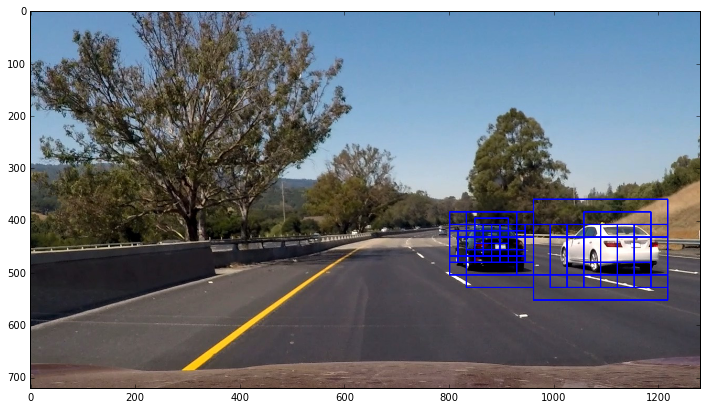

In [25]:
# Test the function
image = mpimg.imread('./test_images/test6.jpg')
on_windows = search_windows(image, windows=all_windows, clf=svc, color_space='LUV', 
                            resize=(32, 32), 
                            spatial_size=(16, 16), 
                            hist_bins=32, hist_range=(0, 256), 
                            orient=8, pix_per_cell=4, cell_per_block=1, 
                            vis=False, feature_vec=True, hog_channel=0, 
                            X_scaler = X_scaler)

window_img = draw_boxes(image, on_windows, factor=1, color=(0, 0, 255), thick=2)
fig = plt.figure(figsize=(12,8))
plt.imshow(window_img)

### 3.3 Combine overlapping detections

#### 3.3.1 Generate heat map by overlaying detected boxes

In [26]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

#### 3.3.2 Apply threshold to the heat map

In [27]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

#### 3.3.3 Do connected region analysis and draw boxes

In [28]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 6)
    # Return the image
    return img

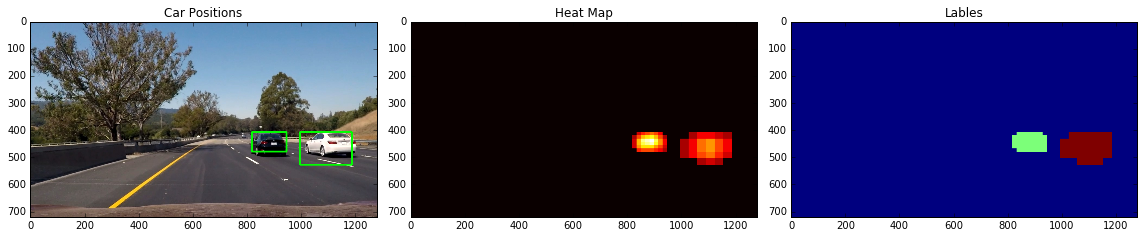

In [29]:
# Test the method
from scipy.ndimage.measurements import label

heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,on_windows)
#heat = add_heat(heat,all_windows)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,3)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure(figsize=(16,4))
plt.subplot(131)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(132)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
plt.subplot(133)
plt.imshow(labels[0])
plt.title('Lables')
fig.tight_layout()

## IV. Video Implementation

This section combines all the procesures of lane-line detection and car detection together. Corresponding steps includes:

* Warp up all functions regarding car detection
* Warp up all functions regarding car lane-line detection
* Define a buffer to store detected windows in past frames to alliviate the false detection problem

Details are in the following.

---

### 4.1 Wrap up all functions above

In [30]:
def car_detection(img, windows, clf, draw_board, 
                  prewindows = [], # previous detected windows
                  color_space='LUV', 
                  resize=(32, 32), 
                  spatial_size=(16, 16), 
                  hist_bins=32, hist_range=(0, 256), 
                  orient=8, pix_per_cell=4, cell_per_block=1, 
                  vis=False, feature_vec=True, hog_channel=0, 
                  X_scaler = None, 
                  heat_threshold = 5):
    
    image = dtype2uint8(img)
    # detected windows in the current frame
    cu_windows = search_windows(image, windows=windows, clf=clf, color_space=color_space, 
                                resize=resize, 
                                spatial_size=spatial_size, 
                                hist_bins=hist_bins, hist_range=hist_range, 
                                orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                vis=vis, feature_vec=feature_vec, hog_channel=hog_channel, 
                                X_scaler = X_scaler)
    # Combine all windows together
    on_windows = cu_windows
    if prewindows is not None and len(np.shape(prewindows)) >= 3 and len(np.shape(cu_windows)) >= 3:
        on_windows = np.vstack([cu_windows,prewindows])
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,on_windows)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,heat_threshold)
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_board = draw_boxes(draw_board, on_windows, factor=1, color=(0, 0, 255), thick=2)
    draw_img = draw_labeled_bboxes(draw_board, labels)
    
    return draw_img, cu_windows

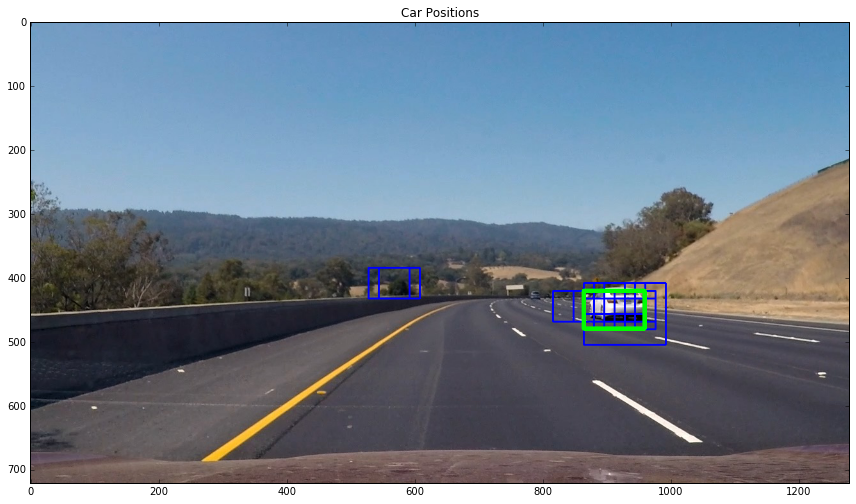

In [31]:
# Test the function
image = mpimg.imread('./test_images/test3.jpg')
draw_img, cu_windows = car_detection(img=image, windows=all_windows, clf=svc, draw_board= np.copy(image), 
                                     prewindows = [], 
                                     color_space='LUV', 
                                     resize=(32, 32), 
                                     spatial_size=(16, 16), 
                                     hist_bins=32, hist_range=(0, 256), 
                                     orient=8, pix_per_cell=4, cell_per_block=1, 
                                     vis=False, feature_vec=True, hog_channel=0, 
                                     X_scaler = X_scaler, 
                                     heat_threshold = 4)
fig = plt.figure(figsize=(12,8))
plt.imshow(draw_img)
plt.title('Car Positions')
fig.tight_layout()

### 4.2 Lane-lines detection pipline

In [32]:
def img_undistort(img, mtx, dist):
    '''
    img: the raw image
    mtx: the camara matrix
    dist: the camara distortion coefficients
    '''
    if img.dtype != 'uint8':
        img = np.uint8(img*255)
    h, w = img.shape[:2]
    # Refine the camera matrix based on a free scaling parameter using cv2.getOptimalNewCameraMatrix()
    newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))
    # undistort
    undist = cv2.undistort(img, mtx, dist, None, newcameramtx)
    
    return undist, roi

In [33]:
def img_unwarp(undist, M, size):
    '''
    undist: undistorted image
    M: the transform matrix
    size: the size of the unwarped image
    '''
    if undist.dtype != 'uint8':
        undist = np.uint8(img*255)
    unwarped = cv2.warpPerspective(undist, M, size, flags=cv2.INTER_LINEAR)
    
    return unwarped

In [34]:
def SV_gray(img):
    '''convert RGB to HSV and merge the SV channels'''
    if img.dtype != 'uint8':
        img = np.uint8(img*255)
    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    s_channel = np.float64(hsv_img[:,:,1])
    v_channel = np.float64(hsv_img[:,:,2])
    gray = np.uint8((0.2*s_channel+v_channel)/1.2)
    return gray

In [35]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, abs_thresh=(0, 255)):
    if img.dtype != 'uint8':
        img = np.uint8(img*255)
    # Convert to grayscale
    gray = SV_gray(img)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.uint8(np.zeros_like(scaled_sobel))
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= abs_thresh[0]) & (scaled_sobel <= abs_thresh[1])] = 255

    # Return the result
    return binary_output

In [36]:
# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    if img.dtype != 'uint8':
        img = np.uint8(img*255)
    # Convert to grayscale
    gray = SV_gray(img)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.uint8(np.zeros_like(gradmag))
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 255

    # Return the binary image
    return binary_output

In [37]:
# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, dir_thresh=(0, np.pi/2)):
    if img.dtype != 'uint8':
        img = np.uint8(img*255)
    # Grayscale
    gray = SV_gray(img)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.uint8(np.zeros_like(absgraddir))
    binary_output[(absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 255

    # Return the binary image
    return binary_output

In [38]:
# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_threshold(img, hls_thresh=(0, 255)):
    if img.dtype != 'uint8':
        img = np.uint8(img*255)
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    s_channel = hls[:,:,2]
    binary_output = np.uint8(np.zeros_like(s_channel))
    binary_output[(s_channel >= hls_thresh[0]) & (s_channel <= hls_thresh[1])] = 255
    # 3) Return a binary image of threshold result
    return binary_output

In [39]:
def combine_threshold(img, 
                      ksize=3, 
                      x_thresh=(0, 255), 
                      y_thresh=(0, 255), 
                      m_thresh=(0, 255), 
                      d_thresh=(0, np.pi/2), 
                      s_thresh=(0, 255)):
    if img.dtype != 'uint8':
        img = np.uint8(img*255)
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, abs_thresh=x_thresh)
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, abs_thresh=y_thresh)
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=m_thresh)
    dir_binary = dir_threshold(img, sobel_kernel=ksize, dir_thresh=d_thresh)
    hls_binary = hls_threshold(img, hls_thresh=s_thresh)
    # Combine each channel
    combined = np.zeros_like(dir_binary)
    combined[(gradx == 255) & 
             (grady == 255) & 
             (mag_binary == 255) & 
             (dir_binary == 255) & 
             (hls_binary == 255)] = 255
    
    # Return the binary image
    return combined

In [40]:
def pipline(image, mtx, dist, M, 
            ksize=3, 
            x_thresh=(0, 255), 
            y_thresh=(0, 255), 
            m_thresh=(40, 255), 
            d_thresh=(np.pi/20, np.pi/2-np.pi/20), 
            s_thresh=(10, 255), 
            nwindows = 9, 
            margin = 100, 
            minpix = 10, 
            left_fit = None, 
            right_fit = None, 
            ym_per_pix = 30/720, 
            xm_per_pix = 3.6/640, 
            decay_factor = 0.9):
    bin_img = combine_threshold(image, 
                            ksize=ksize, 
                            x_thresh=x_thresh, 
                            y_thresh=y_thresh, 
                            m_thresh=m_thresh, 
                            d_thresh=d_thresh, 
                            s_thresh=s_thresh)
    undist, roi = img_undistort(bin_img, mtx, dist)
    unwarped = img_unwarp(undist, M, (undist.shape[1],undist.shape[0]))
    unwarped = cv2.medianBlur(unwarped,5)
    retval, unwarped = cv2.threshold(unwarped, 100, 255, cv2.THRESH_BINARY)
    # Line detection
    if left_fit is None or right_fit is None:
        histogram = np.sum(unwarped[np.int32(unwarped.shape[0]/2):,:], axis=0)
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        # Set height of windows
        window_height = np.int(unwarped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = unwarped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []
        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = unwarped.shape[0] - (window+1)*window_height
            win_y_high = unwarped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & 
                              (nonzeroy < win_y_high) & 
                              (nonzerox >= win_xleft_low) & 
                              (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & 
                               (nonzeroy < win_y_high) & 
                               (nonzerox >= win_xright_low) & 
                               (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    else:
        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!
        nonzero = unwarped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & 
                          (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & 
                           (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    if len(leftx) > minpix*5:
        if left_fit is not None:
            left_fit = np.polyfit(lefty, leftx, 2)*(1-decay_factor) + left_fit*decay_factor
        else:
            left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) > minpix*5:
        if right_fit is not None:
            right_fit = np.polyfit(righty, rightx, 2)*(1-decay_factor) + right_fit*decay_factor
        else:
            right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, unwarped.shape[0]-1, unwarped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Calculate the position of the left line and right line at the bottom of the image
    left_center_x = left_fit[0]*unwarped.shape[0]**2 + left_fit[1]*unwarped.shape[0] + left_fit[2]
    right_center_x = right_fit[0]*unwarped.shape[0]**2 + right_fit[1]*unwarped.shape[0] + right_fit[2]
    # conversions from pixels space to meters and calculate the offset from the center
    offset_cr = (unwarped.shape[1]/2-(left_center_x+right_center_x)/2)*xm_per_pix
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(unwarped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255,0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    Minv = np.linalg.inv(M)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image (undistorted)
    undist_img, roi = img_undistort(image, mtx, dist)
    result = cv2.addWeighted(undist_img, 0.7, newwarp, 0.3, 0)
    #x,y,w,h = roi
    #result = result[y:y+h, x:x+w]
    cv2.putText(result, 
                'Radius of Curvature = {} (m)'.format(int((left_curverad+right_curverad)/2)), 
                org = (30,50), 
                fontFace = cv2.FONT_HERSHEY_SIMPLEX, 
                fontScale = 2, 
                color = (255,255,255), 
                thickness = 2)
    cv2.putText(result, 
                'Vehicle is {:03.2f}m right of center'.format(offset_cr), 
                org = (30,100), 
                fontFace = cv2.FONT_HERSHEY_SIMPLEX, 
                fontScale = 2, 
                color = (255,255,255), 
                thickness = 2)
    return result, roi, left_fit, right_fit, undist_img

### 4.3 Car detection pipline

In [41]:
# Define a buffer to store detected windows in past frames
# These buffered windows are used to smooth the detection and aliviate the false detection problem
class windows_buf:
    def __init__(self, sz):
        self.size = sz # The size of the buffer
        self.num = 0 # The number of frames stored in the buffer
        self.buf = []
    
    # push detected windows to the buffer
    def push_wins(self, wins):
        if wins is not None:      
            if len(np.shape(wins)) == 2:
                self.buf.extend([[wins]])
                self.num += 1
            elif len(np.shape(wins)) == 3:
                self.buf.extend([wins])
                self.num += 1
            if len(self.buf) > self.size:
                self.buf = self.buf[-self.size:]
                self.num = self.size
    
    # Concatenate buffered windows
    def get_concate(self):
        result = []
        if self.num > 0:
            result = np.concatenate(self.buf)
        return result

In [81]:
# Note: the conda version of cv2.VideoCapture and cv2.VideoWriter work on Mac but not Ubuntu16!
# If you are using Ubuntu16, please use the skvideo.io library instead!
cap = cv2.VideoCapture('./project_video.mp4')

fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v') # note the lower case
out = cv2.VideoWriter('./project_output.mp4',fourcc, 30, (1280,720))

# Load camara calibration related parameters
mtx = np.load('mtx.npy')
dist = np.load('dist.npy')
M = np.load('M.npy')

left_fit = None
right_fit = None
on_wins_buf = windows_buf(5)
while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()
    if ret == True:
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        result, roi, left_fit, right_fit, undist_img = pipline(image, mtx, dist, M, 
                                                                ksize=3, 
                                                                x_thresh=(0, 255), 
                                                                y_thresh=(0, 255), 
                                                                m_thresh=(30, 255), 
                                                                d_thresh=(np.pi/20, np.pi/2-np.pi/20), 
                                                                s_thresh=(30, 255), 
                                                                nwindows = 9, 
                                                                margin = 80, 
                                                                minpix = 20, 
                                                                left_fit = left_fit,
                                                                right_fit = right_fit, 
                                                                ym_per_pix = 50/720, 
                                                                xm_per_pix = 3.6/640, 
                                                                decay_factor = 0.9)
        draw_img, cu_windows = car_detection(img=undist_img, windows=all_windows, clf=svc, draw_board = result, 
                                             prewindows = on_wins_buf.get_concate(), 
                                             color_space='LUV', 
                                             resize=(32, 32), 
                                             spatial_size=(16, 16), 
                                             hist_bins=32, hist_range=(0, 256), 
                                             orient=8, pix_per_cell=4, cell_per_block=1, 
                                             vis=False, feature_vec=True, hog_channel=0, 
                                             X_scaler = X_scaler, 
                                             heat_threshold = 25)
        on_wins_buf.push_wins(cu_windows)
        
        # Display the resulting frame
        draw_img_BGR = cv2.cvtColor(draw_img, cv2.COLOR_RGB2BGR)
        out.write(draw_img_BGR)
        cv2.imshow('result',draw_img_BGR)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break

# When everything done, release the capture
cap.release()
out.release()
cv2.destroyAllWindows()